## Let's demo RivGraph on a mouse brain!
This demo walks through some steps for using RivGraph on non-river masks. This particular example is a scan of a mouse brain provided by the authors of [this paper](https://rdcu.be/ccn0Y). However, any binary mask can be transformed into its graphical representation with RivGraph.

The main difference in our approach here is that we can no longer use the convenient `delta` or `river` classes to manage our processing. Instead of applying the methods of those classes, we will directly call the functions we need. This demo will cover the following:

1. Making a mask from a grayscale image
2. Tidying up the mask using RivGraph tools
3. Computing a graphical representation of the mask
4. Pruning the network
5. Converting the graph to a NetworkX object for further topologic analyses.

Some ideas for exporting results will be shown along the way. RivGraph was designed primarily for georeferenced masks, and thus al its export functionality requires some kind of georeferencing information. However, there are other options available for storing analysis results, which we'll demonstrate here.

In [1]:
import skimage
from skimage import io

### 1. Making a mask from a grayscale image

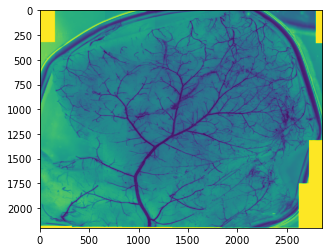

In [2]:
from skimage import io
from matplotlib import pyplot as plt

path_brain = "./data/Mouse_Brain/brain_scan.png"

# Read the grayscale image of a brain scan
I = io.imread(path_brain, as_gray=True)

# Look at it
plt.imshow(I)

Pretty cool. This is a 2-D scan of a 3-D mouse brain. What we're seeing in dark blue is the network of blood vessels that we'd like to represent graphically. Note that the ends of most of the blood vessels aren't acutally *ending*, but rather *diving* further into (or out of) the plane of the image.

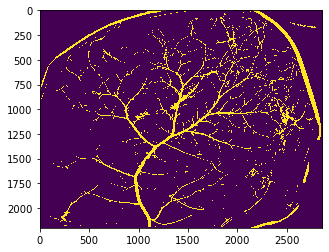

In [3]:
# The first thing we need to do is to binarize the image. 
# To do this, we can play around with a threshold value of the grayscale image.
# After some trials, it looks like pixel values less than 60 captures the blood vessels fairly well.
Ib = I<60

# Note that we set the interpolation to 'none' (not None).
plt.imshow(Ib, interpolation='none')

We now have a binary image of the brain's vascular network. But it also contains some features that we're not interested in, like the circumference of the brain. Remember that we want our mask to contain *only* the features that we want to include in our graph. In the next code block, we'll use some RivGraph tools to clean up the mask a little.

### 2. Tidying up the mask

C:\Users\Jon\Anaconda3\envs\rg04\lib\site-packages\rivgraph\im_utils.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out[prop] = np.array(coords)


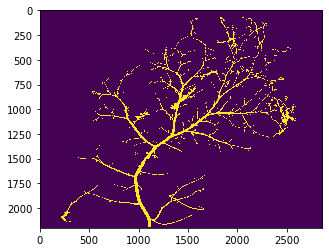

In [4]:
# Import our "image utilities"
from rivgraph import im_utils as iu

# First, let's remove anything that isn't connected to the largest blob of the image
Ib = iu.largest_blobs(Ib, action='keep') # action can also be 'remove' if we want to delete it instead

# Now take a look
plt.imshow(Ib, interpolation='none')

Retaining only the largest "blob" did a good job of removing many of the objects that we didn't want. If we zoom into the mask, we see that the thresholding has resulted in a little "salt and pepper" noise, represented by small holes. Next, we will fill these holes.

Text(0.5, 1.0, 'Holes filled')

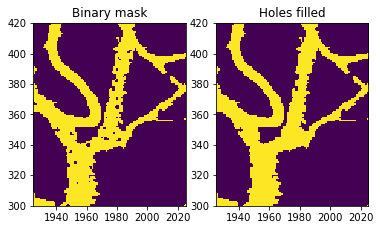

In [5]:
# Fill small holes in the mask. 
Ihf = iu.fill_holes(Ib, maxholesize=100) # maxholesize is # of pixels the largest hole can be; anything smaller will be filled

# Plot for comparison
fig, ax = plt.subplots(1,2)
ax[0].imshow(Ib, interpolation='none')
ax[1].imshow(Ihf, interpolation='none')
xlims = [1925, 2025]
ylims = [300, 420]
ax[0].set_xlim(xlims)
ax[0].set_ylim(ylims)
ax[1].set_xlim(xlims)
ax[1].set_ylim(ylims)
ax[0].set_title('Binary mask')
ax[1].set_title('Holes filled')

We also see that the edges of some of the vessels are somewhat sawtoothed (rough, not smooth). We can use morphological erosion and dilation to try to smooth these edges if desired. In many cases, the roughness is not important and we can proceed as-is. The risk of using `erode` and `dilate` is that we can either join objects that should not be joined, or break connectivity where it should not be broken. Let's see what happens.

(300.0, 420.0)

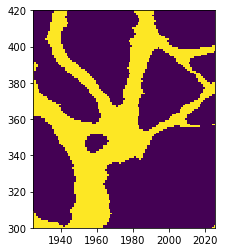

In [6]:
# Dilate first, then erode
Ic = iu.dilate(Ihf, n=1, strel='disk') # n is number of times to dilate, strel is the kernel shape (from skimage)
Ic = iu.erode(Ic, n=1, strel='disk')

plt.imshow(Ic, interpolation='none')
plt.xlim(xlims)
plt.ylim(ylims)

The edges are certainly smoother, but we've also created a connection between two arteries that didn't exist before. Smoother boundaries are not critical for extracting the network, since RivGraph traces the skeleton of the objects. So we might choose not to smooth the boundaries at all. 

There are a few other places where the mask is somewhat messy that we might want to clean up. We can touch these areas up by hand. We could use RivGraph's hand_clean function, but because there are so many places to edit, I will just use Paint.NET, and we will re-load the hand cleaned mask here.

### 3. Computing a graphical representation of the mask

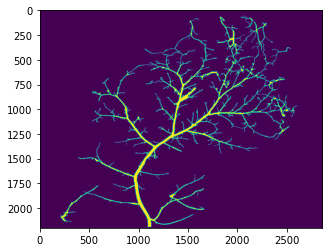

In [38]:
# Load the hand-cleaned mask
path_handcleaned = "./data/Mouse_Brain/brain_scan_handcleaned.png"
Ic = io.imread(path_handcleaned, as_gray=True)
Ic = iu.largest_blobs(Ic, action='keep')

# Plot to ensure we've loaded the image correctly
plt.imshow(Ic, interpolation=None)

Ok, we now have a "clean" mask. We can now extract its links and nodes, and compute their lengths and widths.

In [39]:
from rivgraph import mask_to_graph as m2g
Iskel = m2g.skeletonize_mask(Ic) # Generate the skeleton
links, nodes = m2g.skel_to_graph(Iskel) # Vectorize the skeleton

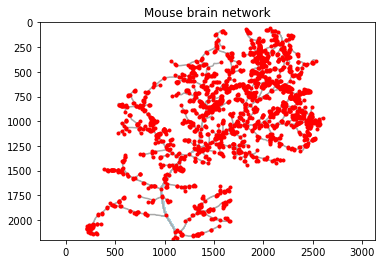

In [40]:
# Let's plot the resulting network
# We'll turn off the link and node label id's so we can see the network better
from rivgraph import ln_utils as lnu
lnu.plot_network(links, nodes, Ic, name='Mouse brain network', label_links=False, label_nodes=False)

Now that we have the links and nodes dictionaries, let's compute the lengths and widths of each link. We'll need to first compute the distance transform, which is used to calculate widths.

In [41]:
from scipy.ndimage.morphology import distance_transform_edt
Idt = distance_transform_edt(Ic)
links = lnu.link_widths_and_lengths(links, Idt)
print(links.keys())

dict_keys(['idx', 'conn', 'id', 'n_networks', 'wid_pix', 'len', 'wid', 'wid_adj', 'len_adj'])


We see that the 'wid', 'len', 'wid_adj', and 'len_adj' keys have been added to the dictionary.

At this point, we may wish to design some filtering algorithm that simplifies our network. For example, we might want to remove "dangling" links, or those connected to the network at only one end.

### 4. Pruning the network

In [37]:
print(len(nodes['id']))

dangling_link_ids = []
for nconn in nodes['conn']:
    if len(nconn) == 1:
        dangling_link_ids.append(nconn[0])

print(sorted(dangling_link_ids)[:10])

2109
[0, 1, 1, 2, 2, 5, 6, 9, 10, 12]


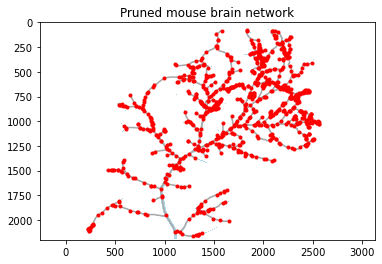

In [43]:
# We can find the dangling links by using the nodes 'conn' property, which
# lists the link ids connected to each node. If any nodes have only one entry
# in the 'conn' list, we know it's a dangling link.
dangling_link_ids = []
for nconn in nodes['conn']:
    if len(nconn) == 1:
        dangling_link_ids.append(nconn[0])
        
# Now that we have the dangling link ids, we can remove them. We need to use
# RivGraph's delete_link function to ensure the nodes dictionary is also
# updated appropriately.
for dli in dangling_link_ids:
    links, nodes = lnu.delete_link(links, nodes, dli)
    
# Finally, let's plot the prouned network
lnu.plot_network(links, nodes, Ic, name='Pruned mouse brain network', label_links=False, label_nodes=False)

The pruning we did halved the number of links in the network. It might not be appropriate for the questions we want to answer about this network; you may have to design your own pruning schemes. Just be sure to use the RivGraph functions for removing links and nodes, else your network will become corrupt.

Finally, let's put our pruned network into a NetworkX object.

### 5. Converting the graph to a NetworkX object

In [ ]:
from rivgraph.deltas import delta_metrics as dm
G = dm.graphiphy(links, nodes)
print(G)

G is a NetworkX object representing our graphed mouse brain. You can also create adjacency matrices, weighted adjacency matrices, etc. and use all the methods and functions provided in NetworkX to analyze the graph (G). 